# Multiple Linear Regression
Here we use the Linear Regression method on the converted data from the descriptive_analysis.ipynb.

https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.linear_model import LassoCV
from datetime import datetime, timedelta
from scipy import stats
np.random.seed(1)

In [68]:
# Read in data, set index to column 0, parse dates and display first 5 rows
test = pd.read_csv('./data/converted_test_2020_07_17_12-15-40.csv', index_col=0)
train = pd.read_csv('./data/converted_train_2020_07_17_12-15-40.csv', index_col=0)
train.head(5)

,Request_Date,Flight_Date,Duration_Time,Departure_hour,flight_unique_id,route_abb,flight_number,Price,Currency,min_future_price,...,min_future_price_in_eur,Request_Weekday,Request_timeofday,Departure_timeofday,flight_distance_km,Request_hour,Request_Date_Month,Flight_Date_Month,route_abb_from,route_abb_to
0,2019-06-03 11:00:00,2019-06-05 19:00:00,56.0,19,2019-06-05 FR 146,SXF-STN,FR 146,208.07,€,259.07,...,259.070000,Monday,Morning,Evening,907.2,11,6,6,SXF,STN
1,2019-06-03 23:00:00,2019-06-05 19:00:00,44.0,19,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,...,259.070000,Monday,Night,Evening,907.2,23,6,6,SXF,STN
2,2019-06-04 11:00:00,2019-06-05 19:00:00,32.0,19,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,...,259.070000,Tuesday,Morning,Evening,907.2,11,6,6,SXF,STN
3,2019-06-04 23:00:00,2019-06-05 19:00:00,20.0,19,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,...,259.070000,Tuesday,Night,Evening,907.2,23,6,6,SXF,STN
4,2019-06-03 11:00:00,2019-06-05 21:00:00,58.0,21,2019-06-05 FR 147,STN-SXF,FR 147,127.49,£,223.37,...,252.059401,Monday,Morning,Night,907.2,11,6,6,STN,SXF


In [69]:
# Check for nulls
print(train.isnull().values.any())
print(test.isnull().values.any())

False
False


# Date preperation

We will now do some minor modifications to put our data into machine-understandable terms. We will use the Python library Pandas for the data manipulation relying on the structure known as dataframe.

The first step is the one-hot-encoding of the data. This process takes categorical variables, such as days of the week and converts it to a numerical representation without an arbitrary ordering.

In [70]:
# One Hot encoding for categorical values / Drop first category is a must for linear regression
train = pd.get_dummies(train, columns=['Request_Weekday', 'Request_timeofday', 'Departure_timeofday', 'route_abb_from', 'route_abb_to'], drop_first=True)
test = pd.get_dummies(test, columns=['Request_Weekday', 'Request_timeofday', 'Departure_timeofday', 'route_abb_from', 'route_abb_to'], drop_first=True)

In [71]:
# Add train column
test['train'] = 0
train['train'] = 1

# Equal columns across both tables
combined = pd.concat([train,test], sort=False)
train = combined[combined['train'] == 1]
test = combined[combined['train'] == 0]

# Fill NaN with 0
train = train.fillna(0)
test = test.fillna(0)

# Drop train column
test.drop(['train'], axis=1, inplace=True)
train.drop(['train'], axis=1, inplace=True)

In [72]:
# Scale train and test data
scaler = preprocessing.StandardScaler()
training_features_log = [['min_future_price_in_eur', 'Duration_Time', 'price_in_eur', 'flight_distance_km']]
for feature in training_features_log:
    train[feature] = scaler.fit_transform(train[feature])
    

testing_features_log = [['Duration_Time', 'price_in_eur', 'flight_distance_km']]
for feature in testing_features_log:
    test[feature] = scaler.fit_transform(test[feature])

In [73]:
# Drop columns we do not need from train
train_dropped = train.drop(columns=['route_abb', 'min_future_price', 'Currency', 'flight_unique_id', 'Price', 'Request_Date', 'Flight_Date', 'Request_Date_Month', 'Flight_Date_Month', 'Request_hour', 'flight_number'])

# Drop columns we do not need from test
test_dropped = test.drop(columns=['route_abb', 'min_future_price', 'Currency', 'flight_unique_id', 'Price', 'min_future_price', 'min_future_price_in_eur', 'Request_Date', 'Flight_Date', 'Request_Date_Month', 'Flight_Date_Month', 'Request_hour', 'flight_number'])

In the next step we separate the data into the features and target. The target, also known as the label, is the value we want to predict, in this case the min_future_price and the features are all the columns the model uses to make a prediction.

In [74]:
# Generate test and target
X = train_dropped.drop(columns=['min_future_price_in_eur'])
y = train_dropped['min_future_price_in_eur'].values

In [75]:
test_dropped

,Duration_Time,Departure_hour,price_in_eur,flight_distance_km,Request_Weekday_Monday,Request_Weekday_Saturday,Request_Weekday_Sunday,Request_Weekday_Thursday,Request_Weekday_Tuesday,Request_Weekday_Wednesday,Request_timeofday_Night,Departure_timeofday_Morning,Departure_timeofday_Night,route_abb_from_STN,route_abb_from_SXF,route_abb_to_STN,route_abb_to_SXF
0,0.257690,7,-0.981366,0.757632,1,0,0,0,0,0,0,1,0,1,0,0,1
1,0.222206,7,-0.761101,0.757632,1,0,0,0,0,0,1,1,0,1,0,0,1
2,0.186723,7,-0.762034,0.757632,0,0,0,0,1,0,0,1,0,1,0,0,1
3,0.151240,7,-0.762034,0.757632,0,0,0,0,1,0,1,1,0,1,0,0,1
4,0.115757,7,-0.761202,0.757632,0,0,0,0,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,-1.578570,22,-0.787429,0.757632,0,0,0,0,1,0,1,0,1,0,1,1,0
5579,-1.614053,22,-0.660917,0.757632,0,0,0,0,0,1,0,0,1,0,1,1,0
5580,-1.649537,22,-0.660917,0.757632,0,0,0,0,0,1,1,0,1,0,1,1,0
5581,-1.685020,22,-0.660917,0.757632,0,0,0,1,0,0,0,0,1,0,1,1,0


# Checking for Linearity

Before executing a linear regression model, we check if a linear relationship between the dependent variable (min_future_price_eur) and the independent variables exists.

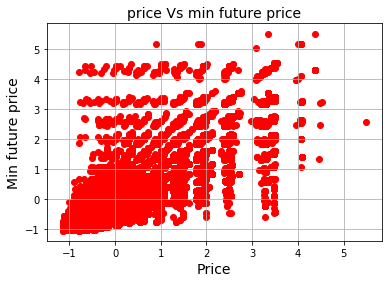

In [76]:
df_lin = pd.DataFrame(train)
 
plt.scatter(df_lin['price_in_eur'], df_lin['min_future_price_in_eur'], color='red')
plt.title('price Vs min future price', fontsize=14)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Min future price', fontsize=14)
plt.grid(True)
plt.show()

We can see that a linear relationship between the price and the min_future_price exists. Specifically, when the price goes up the min_future_price also goes up.

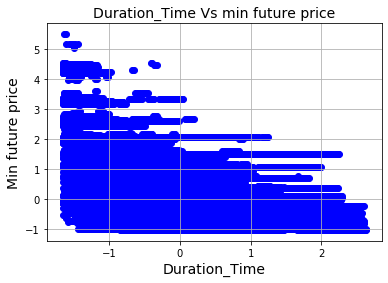

In [77]:
plt.scatter(df_lin['Duration_Time'], df_lin['min_future_price_in_eur'], color='blue')
plt.title('Duration_Time Vs min future price', fontsize=14)
plt.xlabel('Duration_Time', fontsize=14)
plt.ylabel('Min future price', fontsize=14)
plt.grid(True)
plt.show()

We can see that a linear relationship between the price and the min_future_price exists. Specifically, when the Duration_Time goes up the min_future_price decreases.

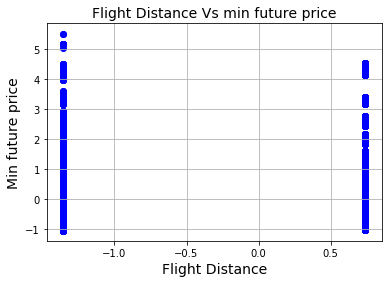

In [78]:
plt.scatter(df_lin['flight_distance_km'], df_lin['min_future_price_in_eur'], color='blue')
plt.title('Flight Distance Vs min future price', fontsize=14)
plt.xlabel('Flight Distance', fontsize=14)
plt.ylabel('Min future price', fontsize=14)
plt.grid(True)
plt.show()

There might be a linear relationship between flight distance and min_future_price. But we do not have enough data.

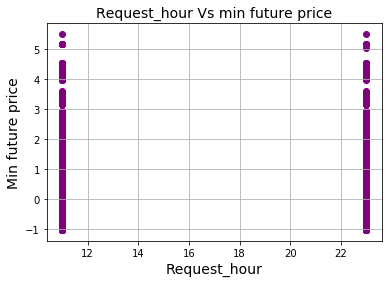

In [79]:
plt.scatter(df_lin['Request_hour'], df_lin['min_future_price_in_eur'], color='purple')
plt.title('Request_hour Vs min future price', fontsize=14)
plt.xlabel('Request_hour', fontsize=14)
plt.ylabel('Min future price', fontsize=14)
plt.grid(True)
plt.show()

There is no linear relationship between request hour and min_future_price

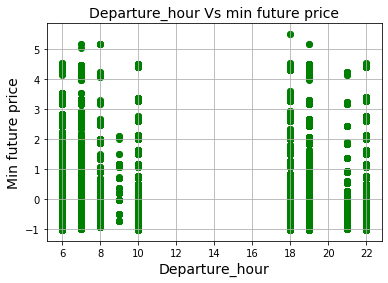

In [80]:
plt.scatter(df_lin['Departure_hour'], df_lin['min_future_price_in_eur'], color='green')
plt.title('Departure_hour Vs min future price', fontsize=14)
plt.xlabel('Departure_hour', fontsize=14)
plt.ylabel('Min future price', fontsize=14)
plt.grid(True)
plt.show()

There is no linear relationship between departure hour and min_future_price

In [81]:
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html
print(stats.pointbiserialr(df_lin['route_abb_from_STN'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['route_abb_from_SXF'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['route_abb_to_STN'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['route_abb_to_SXF'], df_lin['min_future_price_in_eur']))

PointbiserialrResult(correlation=0.037748327876544946, pvalue=9.278150708744796e-28)
PointbiserialrResult(correlation=0.02463582343812651, pvalue=1.0399265762323386e-12)
PointbiserialrResult(correlation=-0.037748327876544974, pvalue=9.278150708744796e-28)
PointbiserialrResult(correlation=0.07165823092252901, pvalue=1.2684529770642404e-95)


There is no significant relationship between route_abb and min_future_price

In [82]:
print(stats.pointbiserialr(df_lin['Request_Weekday_Monday'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['Request_Weekday_Tuesday'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['Request_Weekday_Wednesday'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['Request_Weekday_Thursday'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['Request_Weekday_Saturday'], df_lin['min_future_price_in_eur']))
print(stats.pointbiserialr(df_lin['Request_Weekday_Sunday'], df_lin['min_future_price_in_eur']))

PointbiserialrResult(correlation=-0.01298152445310219, pvalue=0.00017398261320498108)
PointbiserialrResult(correlation=-0.005942139934911538, pvalue=0.08573708001252217)
PointbiserialrResult(correlation=0.0021226459945999565, pvalue=0.5393380141945227)
PointbiserialrResult(correlation=0.008940666499375818, pvalue=0.009724961249875803)
PointbiserialrResult(correlation=0.00038380422371196016, pvalue=0.9116273383345177)
PointbiserialrResult(correlation=-0.0075970694003589774, pvalue=0.028027210061278195)


There is no significant relationship between the request weekday and min_future_price

# Feature importance

LassoCV to evaluate the most valuable features. From the above analysis only price_in_eur and Duration_Time can be used

In [83]:
# Features with the highest absolute coef_ value are considered the most important
feature_names = X.columns
clf = LassoCV(cv=6).fit(X, y)
print(clf.score(X, y))
importance = np.abs(clf.coef_)
print(importance)

0.8144445916175245
[0.12921158 0.00102563 0.81199253 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [84]:
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01

idx_features = (-importance).argsort()[:2]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))

sfm = SelectFromModel(clf, threshold=threshold)
sfm.fit(X, y)
X_transform = sfm.transform(X)

n_features = sfm.transform(X).shape[1]

Selected features: ['price_in_eur' 'Duration_Time']


LassoCV shows that the features with the highest absolute coef_ value are price_in_eur and Duration_Time. Good!

In [85]:
features = name_features
X = X[features]

# Build model

During training, we let the model ‘see’ the answers, in this case the min_future_price_inr_eur, so it can learn how to predict the price from the features. 
We split 80% of the data to the training set and 20% to the testing set. We set the random state to  1 which means the results will be the same each time I run the split for reproducible results.

In [86]:
# Split dataset into train and test data (might want to try random_state=0 to randomize each calculation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

We look at the shape of all the data to make sure we did everything correctly. The training features number of columns match the testing feature number of columns and the number of rows match for the respective training and testing features and the labels:

In [87]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((66899, 2), (66899,), (16725, 2), (16725,))

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler

lin_model = lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [89]:
df_pred = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_pred

,Actual,Predicted
0,0.031005,0.328815
1,2.616126,3.026287
2,-0.793637,-0.863541
3,3.231682,2.241413
4,-0.089139,0.239162
...,...,...
16720,-0.795177,-0.908142
16721,1.987986,1.640245
16722,-0.715895,-0.902071
16723,-0.289374,-0.559172


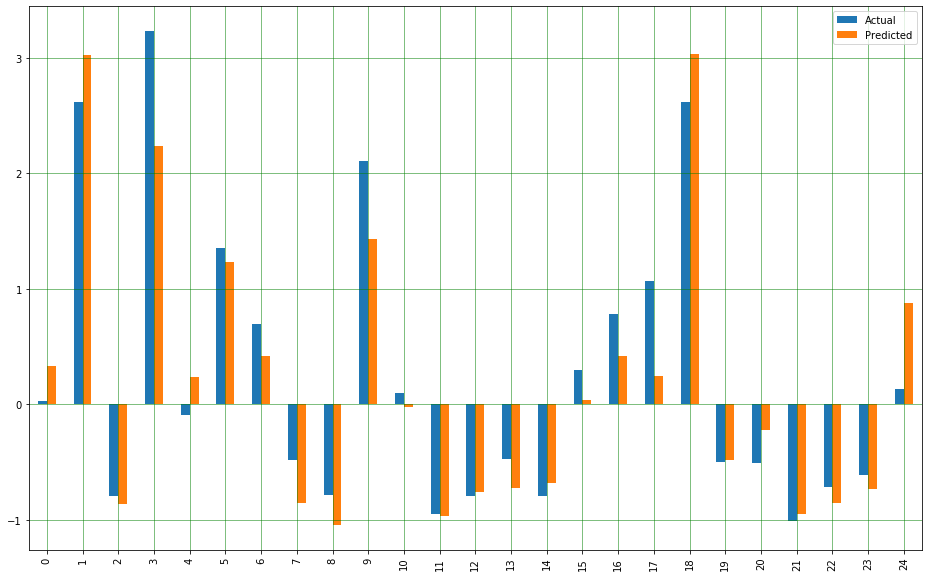

In [90]:
df_pred.head(25).plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Model Evaluation Metrics for Regression

We evaluate the performance of the algorithm. For regression algorithms, three evaluation metrics are commonly used. Mean Absolute Error (MAE), Mean Squared Error (MSE) and the Root Mean Squared Error (RMSE). For these metrics we are using the test data. 

In [91]:
# Return the mean accuracy on the given test data and labels
print('Score:', lin_reg.score(X_test, y_test))

# Return the mean accuracy on the given test data and labels with cross validation 
scores = cross_val_score(lin_model, X, y, cv=6)
print('Cross-validated scores:', scores)

Score: 0.8100225118711449
Cross-validated scores: [0.74259783 0.78854976 0.81053998 0.78538463 0.76289933 0.77070407]


With our model we have a mean accuracy of 87.8%. With Cross Validation we have a worse result where 82.6% is the highest. 

In [92]:
# Calculate the absolute errors
errors = abs(y_pred - y_test)

# Print out the mean absolute error (MAE)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Print out the mean squared error (MSE)
print('Mean Squared Error:', round(np.square(errors).mean(), 2))  

# Print out the root mean squared error (RMSE)
# Lower values of RMSE indicate better fit
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2))

Mean Absolute Error: 0.27
Mean Squared Error: 0.19
Root Mean Squared Error: 0.44


# Use on Test Data

In [93]:
test_pred = lin_reg.predict(np.array(test_dropped[features]))

In [94]:
final_pred = pd.DataFrame({'Request_Date': test['Request_Date'], 'flight_unique_id': test['flight_unique_id'], 'price_in_eur': test['price_in_eur'], 'min_future_price_eur': test_pred})
final_pred

,Request_Date,flight_unique_id,price_in_eur,min_future_price_eur
0,2019-06-03 11:00:00,2019-07-02 FR 145,-0.981366,-0.844658
1,2019-06-03 23:00:00,2019-07-02 FR 145,-0.761101,-0.658046
2,2019-06-04 11:00:00,2019-07-02 FR 145,-0.762034,-0.653892
3,2019-06-04 23:00:00,2019-07-02 FR 145,-0.762034,-0.648967
4,2019-06-05 11:00:00,2019-07-02 FR 145,-0.761202,-0.643357
...,...,...,...,...
5578,2019-07-30 23:00:00,2019-08-02 FR 8545,-0.787429,-0.429855
5579,2019-07-31 11:00:00,2019-08-02 FR 8545,-0.660917,-0.320576
5580,2019-07-31 23:00:00,2019-08-02 FR 8545,-0.660917,-0.315651
5581,2019-08-01 11:00:00,2019-08-02 FR 8545,-0.660917,-0.310727


# Compute Buy False/True

In [95]:
final_pred['buy'] = np.nan
for index, row in final_pred.iterrows():
    if row.price_in_eur > row.min_future_price_eur:
        final_pred.set_value(index,'buy',0)
    else:
        final_pred.set_value(index,'buy',1)
print(final_pred)
# final_pred.to_csv('./data/linear_regression_test.csv', sep=',')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


             Request_Date    flight_unique_id  price_in_eur  \
0     2019-06-03 11:00:00   2019-07-02 FR 145     -0.981366   
1     2019-06-03 23:00:00   2019-07-02 FR 145     -0.761101   
2     2019-06-04 11:00:00   2019-07-02 FR 145     -0.762034   
3     2019-06-04 23:00:00   2019-07-02 FR 145     -0.762034   
4     2019-06-05 11:00:00   2019-07-02 FR 145     -0.761202   
...                   ...                 ...           ...   
5578  2019-07-30 23:00:00  2019-08-02 FR 8545     -0.787429   
5579  2019-07-31 11:00:00  2019-08-02 FR 8545     -0.660917   
5580  2019-07-31 23:00:00  2019-08-02 FR 8545     -0.660917   
5581  2019-08-01 11:00:00  2019-08-02 FR 8545     -0.660917   
5582  2019-08-01 23:00:00  2019-08-02 FR 8545     -0.660917   

      min_future_price_eur  buy  
0                -0.844658  1.0  
1                -0.658046  1.0  
2                -0.653892  1.0  
3                -0.648967  1.0  
4                -0.643357  1.0  
...                    ...  ...  
5578 

# Optimization Performance
Das Vorhersagemodell für die Entscheidung Warten oder Kaufen eines Flugtickets soll hinsichtlich der Vorhersagegenauigkeit optimiert werden, d.h. 
Genauigkeit = Anzahl der richtigen Entscheidungen / Anzahl aller Entscheidungen. 

In [96]:
optimize_final_pred = final_pred
def getModelScore(data):
    data['Request_Date'] = pd.to_datetime(data['Request_Date'], format='%Y-%m-%d %H:%M:%S')
    decision_true_total = 0
    unique_flights_id = data['flight_unique_id'].unique()
    for element in unique_flights_id:
        flights = data[data['flight_unique_id'] == element].sort_values('Request_Date', ascending=False)
        for index, flight in flights.iterrows():
            filtered_flights = flights[flights['Request_Date'] >= flight.Request_Date].sort_values('Request_Date', ascending=False)
            if flight.buy == 1:
                filtered_flights = filtered_flights[filtered_flights['price_in_eur'] < flight.price_in_eur]
            if flight.buy == 0:
                filtered_flights = filtered_flights[filtered_flights['price_in_eur'] > flight.price_in_eur]
            if len(filtered_flights) == 0:
                decision_true_total = decision_true_total + 1
    print('True: ' + str(decision_true_total))
    print('Total: ' + str(len(data)))
    return decision_true_total/len(data)

getModelScore(optimize_final_pred)
# 1264 ['price_in_eur' 'Duration_Time']

True: 1264
Total: 5583


0.2264015762135053

In [39]:
check_final_pred = final_pred
def checkDateToBuy(data, flight_unique_id, request_date):
    flights = data[data['flight_unique_id'] == flight_unique_id].sort_values('Request_Date', ascending=False)
    price_saving = 0
    if request_date <= flights.iloc[0].Request_Date:
        flights['Request_Date'] = pd.to_datetime(flights['Request_Date'], format='%Y-%m-%d %H:%M:%S')
        flights = flights[flights['Request_Date'] > request_date].sort_values('Request_Date', ascending=True)
        initialPrice = 0
        flights = flights.reset_index()
        for index, flight in flights.iterrows():
            if index == 0:
                initialPrice = flight.price_in_eur
            if flight.buy == 1:
                price_saving = initialPrice - flight.price_in_eur
                return [request_date, price_saving, flight.Request_Date]
        return 0
    else:
        print('No data available for the supplied Request_Date')

checkDateToBuy(check_final_pred, '2019-07-02 FR 145', datetime(2019, 5, 1))

[datetime.datetime(2019, 5, 1, 0, 0), 0.0, Timestamp('2019-06-03 11:00:00')]

Die Optimierung geschieht nur auf den Trainingsdaten über Kreuzvalidierung.
Wir definieren ein weiteres Maß für die Modellgüte, um die potentielle Geldersparnis durch das Modell zu messen. Dem Vorschlag von Gruppe 2(?) folgend gehen wir von folgender Idee aus:

a) Wir suchen uns einen Flug aus (flight_unique_id), für den wir ein Ticket kaufen möchten

b) Zu einem Zeitpunkt (Request_Date) prüfen wir zum ersten Mal den Preis

c) Wir fragen das Modell, ob wir warten oder kaufen sollen

d) Wenn das Modell empfiehlt zu kaufen, dann kaufen wir das Ticket; weiter bei Schritt f)

e) Wenn das Modell empfiehlt zu warten, dann gehen wir zur zum nächsten Request_Date des Fluges und zurück zu Schritt c); Wenn es keinen nächsten Request_Date für den Flug mehr gibt (letzte Preisabfrage vor Abflug), dann kaufen wir ein Ticket zum aktuellen Preis, egal was es kostet.

f) Wir bestimmen die Differenz zwischen Kaufpreis (Price) und optimalem zukünftigen Preis (min_future_price).



Um die Modellgüte basierend auf dieser Idee zu messen, führen wir das Protokoll oben für jedes Request_Date in b) aus und addieren so die Differenzen aus f) für jeden Flug (flight_unique_id) auf. Diese Summen addieren wir über alle Flüge auf.

Eine effiziente Implementierung wäre, für einen Flug mit dem letzten Request_Date vor dem Abflug zu beginnen und sich dann schrittweise über Request_Date in die Vergangenheit vorzuarbeiten. Beim letzten Request_Date vor Abflug muss ein Ticket gekauft werden, egal was die Empfehlung des Modells ist.

Wenn wir einen Schritt in die Vergangenheit gehen und die Kaufempfehlung dort "warten" ist, dann berechnen wir die Preisdifferenz zum Schritt davor. Wenn die Kaufempfehlung "kaufen" ist, dann berechnen wir die Differenz zwischen Kaufpreis (Price) und optimalem zukünftigen Preis (min_future_price) wie in f).

Wir gehen wieder einen Schritt in die Vergangenheit und handeln/rechnen wie zuvor bis wir die erste Preisabfrage für den Flug erreicht haben.

Auf den Testdaten werden wir die Genauigkeit aus 1. und das Gütemaß aus 3. bestimmen.
Es ist nicht erlaubt, für die Testdaten min_future_price zu berechnen, um die Güte des Modells zu verbessern. Aus Gründen der Fairness möchte ich Sie bitten, hier nicht zu mogeln. Sie dürfen aber für die Testdaten die zusätzlichen Merkmale (Features) berechnen, welche Sie sich für das Modell überlegt haben. Achten Sie dabei bitte darauf, dass Sie keine Informationen aus der Zukunft verwenden, die Sie im Fall einer praktischen Anwendung nicht hätten.
Bedenken Sie beim Bau Ihres Modells, dass Sie ein Ticket kaufen müssen, wenn Sie in den Daten das letzte Request_Date vor Abflug erreicht haben. Wir gehen davon aus, dass wir die Information "letztes Request_Date vor Abflug" bei der Preisabfrage kennen. Sie können dies also den Daten zufügen.
Ich habe das Problem in den Daten behoben, dass für einige Flüge min_future_price scheinbar nicht gestimmt hat. Dies lag daran, dass die letzten Preisabfragen in der Datenaufbereitung fälschlicherweise gelöscht wurden. Weiterhin habe ich die Testdaten neu ausgewählt. Benutzen Sie also bitte die aktuellen Daten in Moodle (ab 17.6. verfügbar).
Das Modell für den Entscheidungsprozess aus 3. zu optimieren ist deutlich schwieriger als der Standard aus 1. Für die Bewertung der Arbeit mit einer 1.0 erwarte ich wenigstens eine ansatzweise Implementierung der Optimierung nach 3., für eine 1.3 wenigstens die gute Beschreibung eines Lösungsansatzes. Eine saubere Bearbeitung der anderen Teile ist natürlich trotzdem grundlegende Voraussetzung.